In [1]:
import sys
sys.path.append('..')

import logging
from astropy import log as logger
logger.setLevel(logging.ERROR)

In [3]:
from gwb.starmodels.models import TGASWideBinaryStarModel
from isochrones import get_ichrone
mist = get_ichrone('mist', simple_extinction=True)

In [4]:
mod = TGASWideBinaryStarModel(mist, 714124, 719738)
mod.obs.print_ascii()

714124-719738
 ╠═  H=(7.90, 0.05) @(0.00, 0 [4.00])
 ║  ╚═  K=(7.72, 0.03) @(0.00, 0 [4.00])
 ║     ╚═  J=(8.54, 0.04) @(0.00, 0 [4.00])
 ║        ╚═  W1=(7.55, 0.04) @(0.00, 0 [4.00])
 ║           ╚═  W2=(7.59, 0.03) @(0.00, 0 [4.00])
 ║              ╚═ 0_1, plax=(30.64,0.31)
 ╚═  H=(7.47, 0.04) @(60.00, 0 [4.00])
    ╚═  K=(7.29, 0.03) @(60.00, 0 [4.00])
       ╚═  J=(8.11, 0.04) @(60.00, 0 [4.00])
          ╚═  W1=(7.21, 0.05) @(60.00, 0 [4.00])
             ╚═  W2=(7.33, 0.03) @(60.00, 0 [4.00])
                ╚═ 0_0, plax=(30.64,0.31)


In [5]:
%timeit mod.lnlike([1.0, 1.0, 9.8, 0.0, 100, 0.1], use_cache=False)

The slowest run took 48696.65 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 304 µs per loop


In [6]:
mod.bounds('AV')

(0, 0.096000000000000002)

In [14]:
from astropy.io import fits
import numpy as np
import pandas as pd

mutext = fits.getdata('../data/isochrone_pairidx_mutexc.fits')
pleiades = fits.getdata('../data/isochrone_pairidx_pleiades.fits')

import numpy as np
all_ids = np.unique(np.concatenate([mutext.star1, mutext.star2, pleiades.star1, pleiades.star2]))

In [17]:
from astropy.coordinates import SkyCoord

c = SkyCoord(tgas.iloc[all_ids].ra, tgas.iloc[all_ids].dec, unit='deg')

In [18]:
from dustmaps.sfd import SFDQuery
sfd = SFDQuery()
AVs = sfd(c)*2.742

In [27]:
AVdf = pd.read_table('../data/AVs.txt', index_col=0, delim_whitespace=True, 
                     names=['tgas_index','AV'])

In [30]:
AVdf.ix[3127].AV

0.38299999999999995

In [21]:
np.savetxt('../data/AVs.txt', np.array([all_ids, AVs]).T, fmt='%i %.3f')

In [6]:
np.savetxt('../data/isochrone_pairidx_mutexc.txt', np.array([mutext.star1, mutext.star2]).T, fmt='%i')
np.savetxt('../data/isochrone_pairidx_pleiades.txt', np.array([pleiades.star1, pleiades.star2]).T, fmt='%i')

In [15]:
tgas = pd.read_hdf('../data/TgasSource.h5')
source_ids = tgas.iloc[all_ids].source_id.values

In [3]:
np.savetxt('../data/isochrone_unique_source_ids.csv', source_ids, fmt='%i')

In [4]:
# Got this table from Gaia archive ADQL query, job 1477619861778O
from astropy.io.votable import parse_single_table
import pandas as pd
import numpy as np
table = parse_single_table("../data/isochrone_xmatch.vot")
xdf = pd.DataFrame(np.array(table.array))

# make G mag uncertainties
xdf['phot_g_mean_mag_error'] = 2.5 * np.log10(1 + xdf.phot_g_mean_flux_error / xdf.phot_g_mean_flux)
xdf.to_csv('../data/isochrone_xmatch.csv')
xdf.index = xdf.source_id

In [5]:
xdf.columns

Index([u'source_id', u'parallax', u'parallax_error', u'phot_g_mean_mag',
       u'phot_g_mean_flux', u'phot_g_mean_flux_error', u'designation', u'j_m',
       u'j_msigcom', u'h_m', u'h_msigcom', u'ks_m', u'ks_msigcom',
       u'designation_2', u'w1mpro', u'w1mpro_error', u'w2mpro',
       u'w2mpro_error', u'w3mpro', u'w3mpro_error', u'phot_g_mean_mag_error'],
      dtype='object')

In [6]:
from isochrones.starmodel import ResolvedBinaryStarModel

def get_photometry(source_id):
    """Returns dictionary of photometry
    """
    s = xdf.ix[source_id]
    d = dict(G=(s.phot_g_mean_mag, s.phot_g_mean_mag_error),
             J=(s.j_m, s.j_msigcom),
             H=(s.h_m, s.h_msigcom),
             K=(s.ks_m, s.ks_msigcom),
             W1=(s.w1mpro, s.w1mpro_error),
             W2=(s.w2mpro, s.w2mpro_error),
             W3=(s.w2mpro, s.w2mpro_error),
             parallax=(s.parallax, s.parallax_error))
    
    systematics = dict(G=0.005, J=0.01, H=0.01, K=0.01, W1=0.01, W2=0.01, W3=0.01,
                      parallax=0.3)
    
    for k,v in systematics.items():
        val, unc = d[k]
        d[k] = (val, np.sqrt(unc**2 + v**2))
    
    return d
    
class TGASWideBinaryStarModel(ResolvedBinaryStarModel):
    def __init__(self, ic, idx1, idx2):
        self.idx1 = idx1
        self.idx2 = idx2
                
        i1 = min(idx1, idx2)
        i2 = max(idx1, idx2)
        name = '{}-{}'.format(i1,i2)
        
        # Get x-matched photometry
        star1 = get_photometry(tgas.iloc[idx1].source_id)
        star2 = get_photometry(tgas.iloc[idx2].source_id)
        
        super(TGASWideBinaryStarModel, self).__init__(ic, star1, star2, name=name)
        

In [7]:
from isochrones import get_ichrone
mist = get_ichrone('mist')

i = 0
mod = TGASWideBinaryStarModel(mist, mutext.star1[i], mutext.star2[i])

In [8]:
mod.obs.print_ascii()

714124-719738
 ╠═  G=(10.43, 0.01) @(0.00, 0 [4.00])
 ║  ╚═  H=(7.90, 0.04) @(0.00, 0 [4.00])
 ║     ╚═  K=(7.72, 0.03) @(0.00, 0 [4.00])
 ║        ╚═  J=(8.54, 0.04) @(0.00, 0 [4.00])
 ║           ╚═  W3=(7.59, 0.02) @(0.00, 0 [4.00])
 ║              ╚═  W1=(7.55, 0.03) @(0.00, 0 [4.00])
 ║                 ╚═  W2=(7.59, 0.02) @(0.00, 0 [4.00])
 ║                    ╚═ 0_1, plax=(30.64,0.31)
 ╚═  G=(9.86, 0.01) @(60.00, 0 [4.00])
    ╚═  H=(7.47, 0.04) @(60.00, 0 [4.00])
       ╚═  K=(7.29, 0.02) @(60.00, 0 [4.00])
          ╚═  J=(8.11, 0.03) @(60.00, 0 [4.00])
             ╚═  W3=(7.33, 0.02) @(60.00, 0 [4.00])
                ╚═  W1=(7.21, 0.05) @(60.00, 0 [4.00])
                   ╚═  W2=(7.33, 0.02) @(60.00, 0 [4.00])
                      ╚═ 0_0, plax=(30.64,0.31)


In [9]:
mod.mnest_basename

'./chains/mist-714124-719738-0_1--0_0-'

In [10]:
mod.fit();

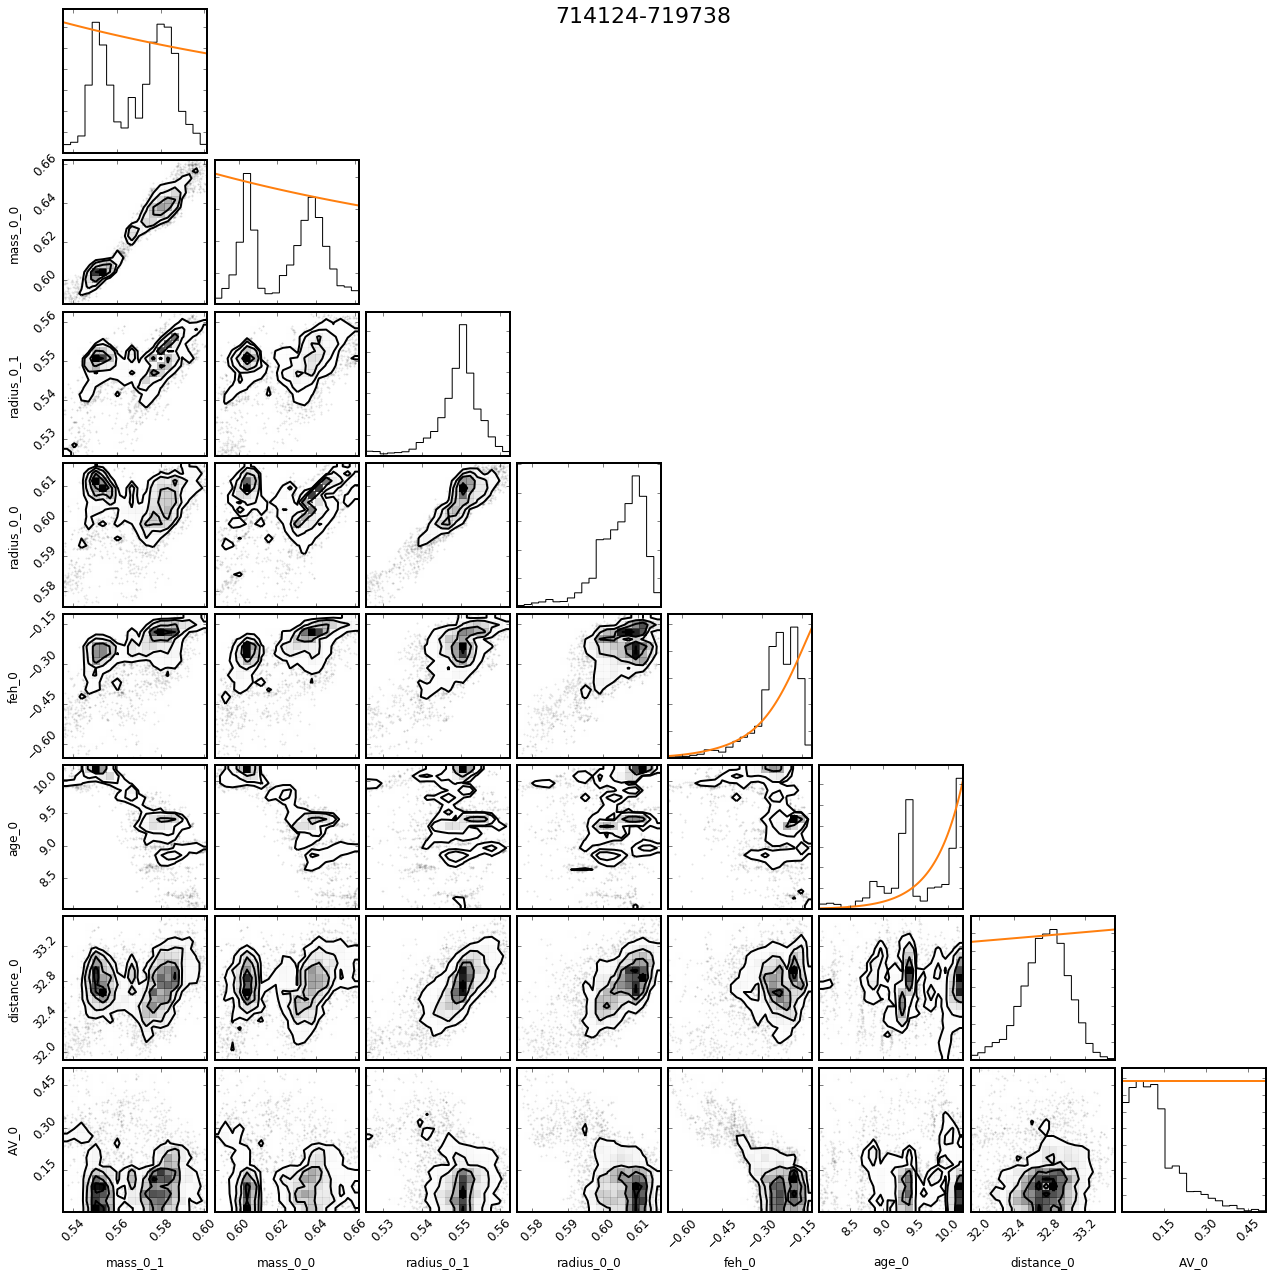

In [11]:
%matplotlib inline

mod.corner_physical();

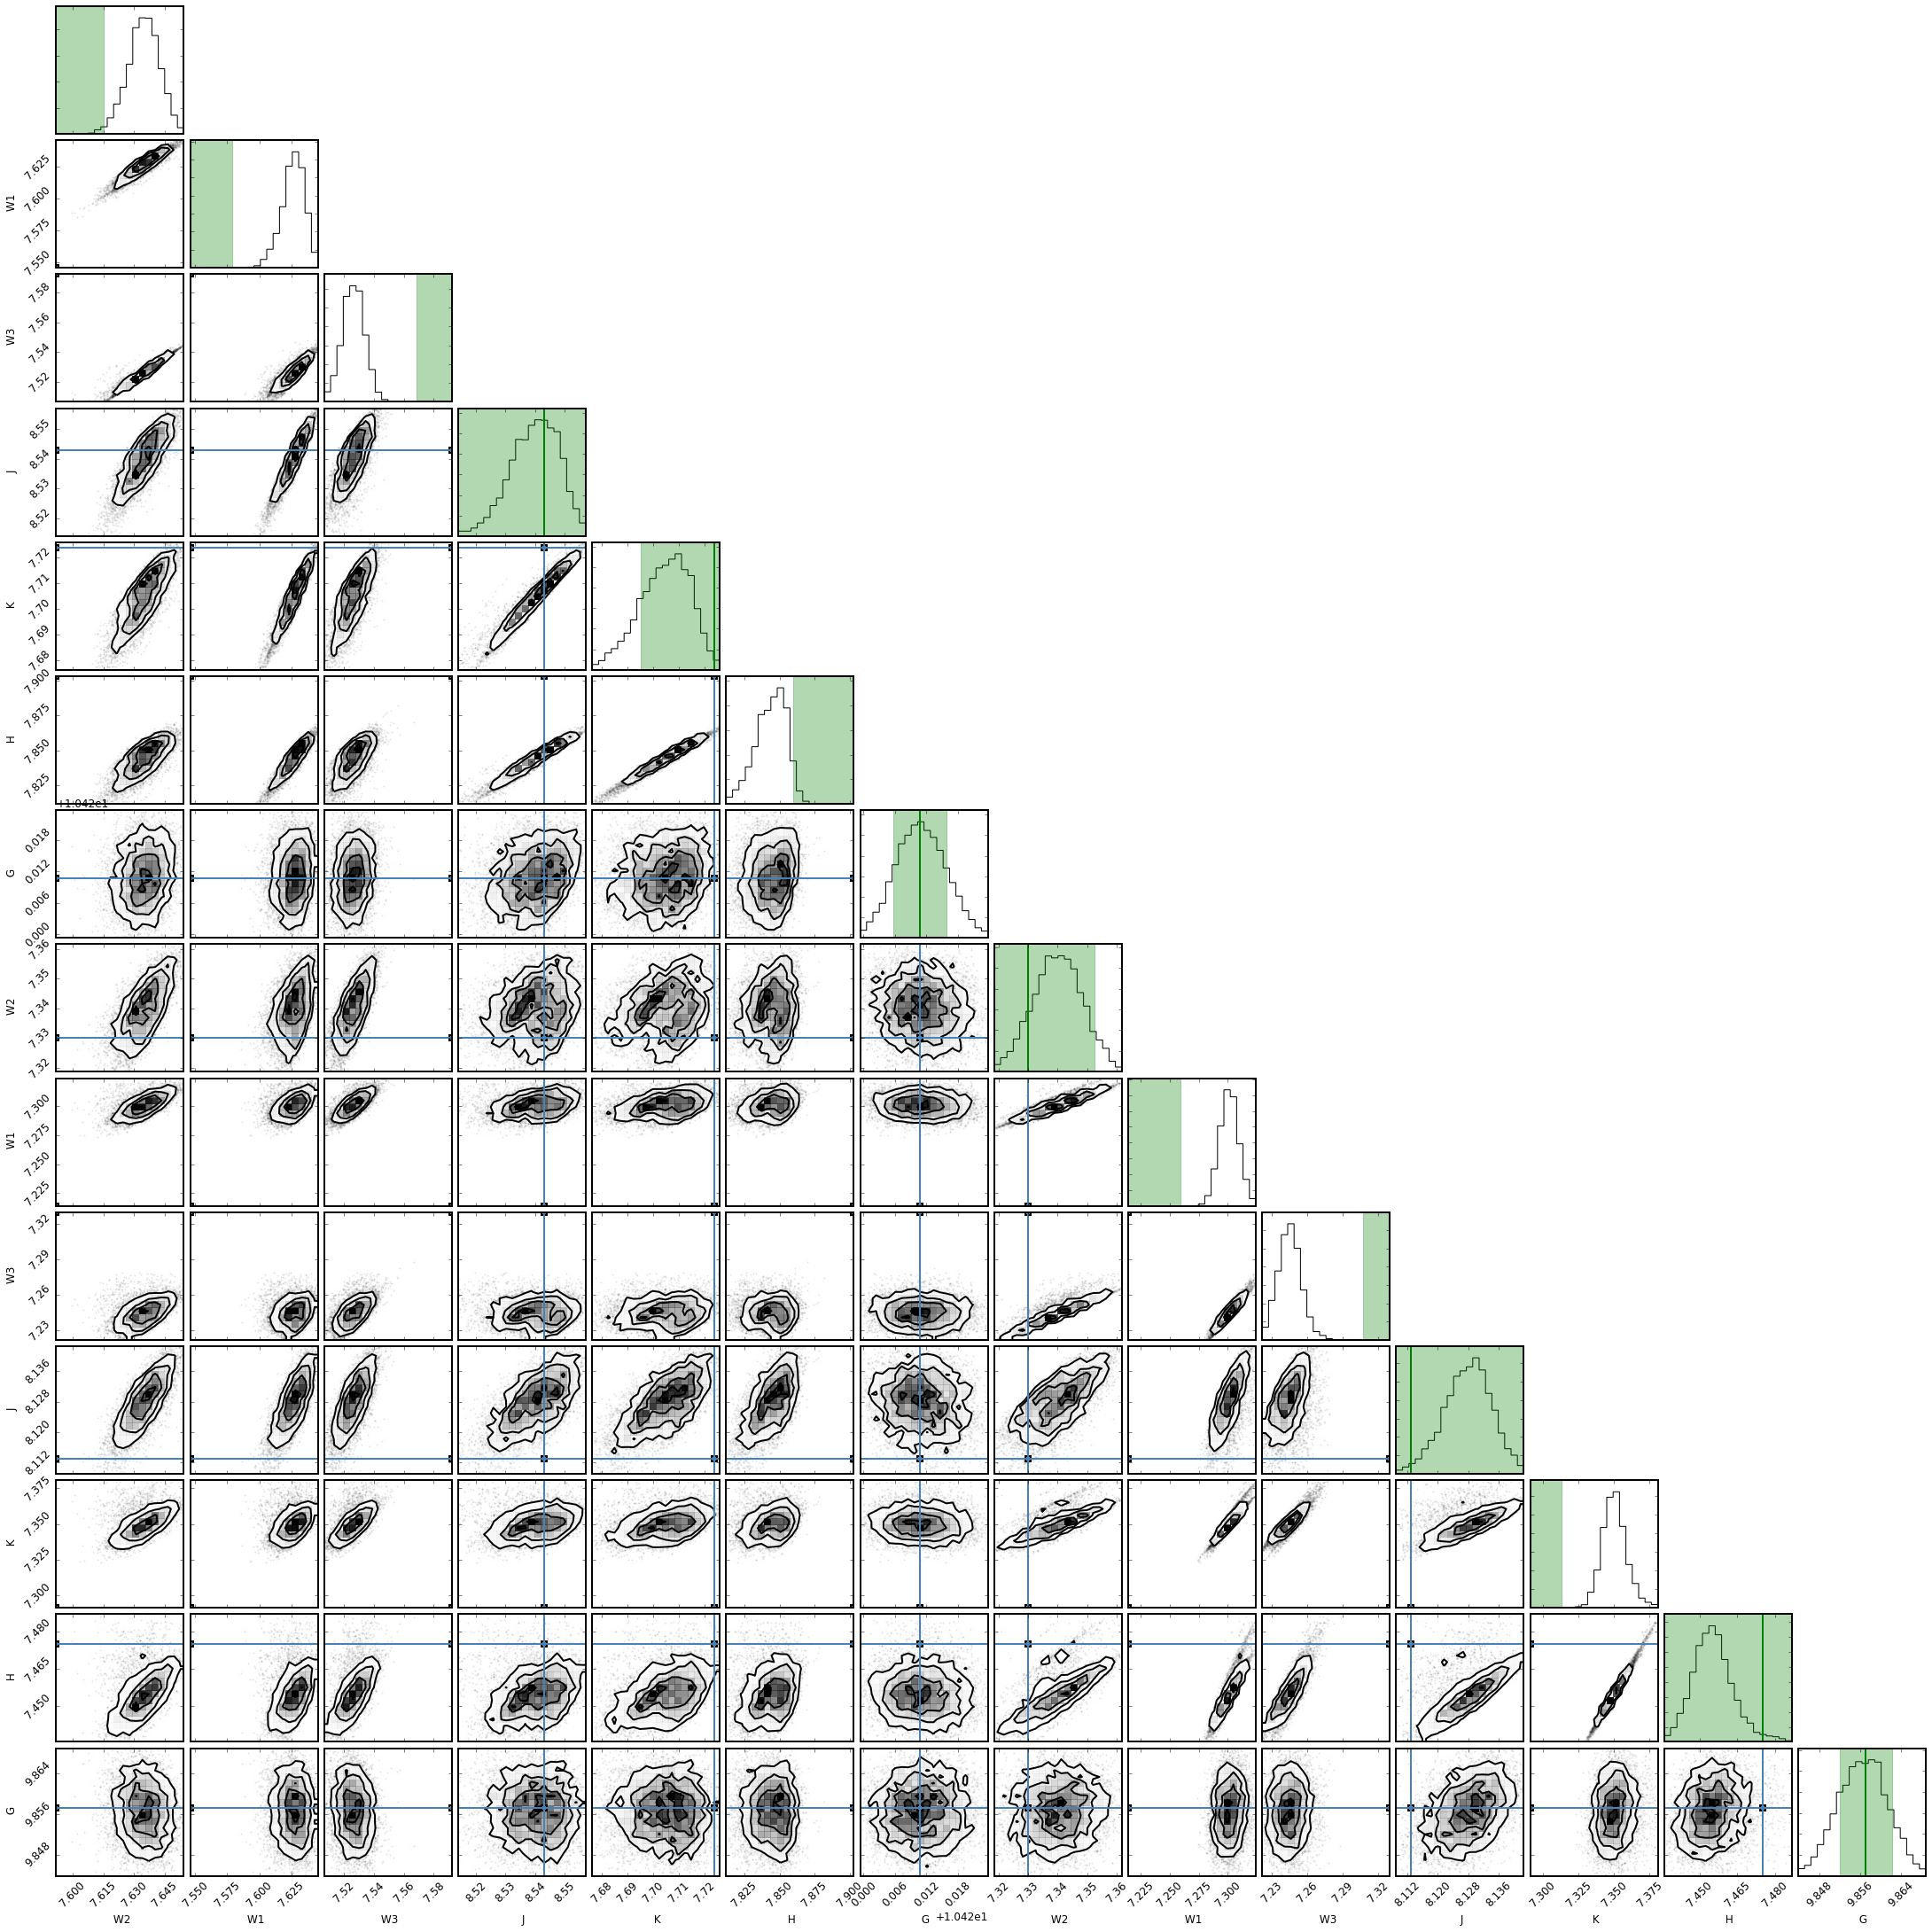

In [12]:
%matplotlib inline

mod.corner_observed();

In [14]:
!say 'fitting is complete!'

In [9]:
mod.obs.name

'root'

In [10]:
mod.obs.parallax

{0: (32.629094533439357, 0.31137353175475319)}

In [21]:
mutext_id1 = TGAS.ix[mutext.star1, 'source_id']
mutext_id2 = TGAS.ix[mutext.star2, 'source_id']

In [1]:
from isochrones.observation import ObservationTree
from isochrones import get_ichrone
mist = get_ichrone('mist')

In [2]:
obs1 = ObservationTree.from_kwargs(mist, J=(10,0.02), H=(9.5,0.02), K=(9.0, 0.02))
obs2 = ObservationTree.from_kwargs(mist, J=(12,0.02), H=(11.3,0.02), K=(10.8, 0.02))
obs = obs1.merge(obs2)
obs.print_ascii()

root
 ╠═  H=(9.50, 0.02) @(0.00, 0 [4.00])
 ║  ╚═  K=(9.00, 0.02) @(0.00, 0 [4.00])
 ║     ╚═  J=(10.00, 0.02) @(0.00, 0 [4.00])
 ╚═  H=(11.30, 0.02) @(60.00, 0 [4.00])
    ╚═  K=(10.80, 0.02) @(60.00, 0 [4.00])
       ╚═  J=(12.00, 0.02) @(60.00, 0 [4.00])


In [65]:
o = obs1.observations[0]

In [67]:
s = o.sources[0]

In [ ]:
s.

In [2]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd

DATADIR = os.getenv('GWBDATA', os.path.expanduser('~/.gwb'))
GAIADIR = os.getenv('GAIADATA', os.path.expanduser('~/.gaia'))
STARMODELDIR = os.path.join(DATADIR, 'starmodels')

In [3]:
TGAS = pd.read_hdf(os.path.join(GAIADIR, 'TgasSource.h5'), 'df')

In [18]:
from astropy.coordinates import SkyCoord
from astropy import units as u

from isochrones.query import Query, TwoMASS, Tycho2, WISE, EmptyQueryError
from isochrones.extinction import get_AV_infinity
import configobj


class TGASQuery(Query):
    """Special subclass for a query based on TGAS DR1.  

    `row` is a row of the Gaia DR1 table.
    """
    def __init__(self, row, radius=5):
        self.row = row
        Query.__init__(self, row.ra, row.dec, row.pmra, row.pmdec, 
                        epoch=2015., radius=radius)

def write_single_ini(i, catalogs=[TwoMASS, Tycho2, WISE]):
    s = TGAS.iloc[i]
    
    directory = os.path.join(STARMODELDIR, 'singles', str(i))
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    ini_file = os.path.join(directory, 'star.ini')
    if os.path.exists(ini_file):
        os.remove(ini_file)
    c = configobj.ConfigObj(ini_file)
    
    # define these coords in epoch=2000
    ra = (s.ra*u.deg - 15*u.yr*s.pmra*u.mas/u.yr).to('deg').value
    dec = (s.dec*u.deg - 15*u.yr*s.pmdec*u.mas/u.yr).to('deg').value
    coords1 = SkyCoord(ra, dec, unit='deg')
    
    c['ra'] = ra
    c['dec'] = dec
    c['maxAV'] = get_AV_infinity(ra, dec)
    c['parallax'] = s.parallax, s.parallax_error 

    q = TGASQuery(s)
    
    for Cat in catalogs:
        sect = configobj.Section(c, 1, c, {})
        empty = True
        
        cat = Cat(q)
        try: 
            mags = cat.get_photometry()
            for b in mags:
                sect[b] = mags[b]
                
            empty = False
        except EmptyQueryError:
            pass

        if not empty:
            n = Cat.name
            c[n] = sect
            c[n]['relative'] = False
            c[n]['resolution'] = 4.

    c.write()
        
def write_binary_ini(i1, i2, catalogs=[TwoMASS, Tycho2, WISE]):
    """ Write ini file for i1-i2 pair
    """
    if not i1 < i2:
        i1, i2 = i2, i1
    
    s1 = TGAS.iloc[i1]
    s2 = TGAS.iloc[i2]
    
    directory = os.path.join(STARMODELDIR, 'binaries', '{}-{}'.format(i1, i2))
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    ini_file = os.path.join(directory, 'star.ini')
    if os.path.exists(ini_file):
        os.remove(ini_file)
    c = configobj.ConfigObj(ini_file)
    
    # define these coords in epoch=2000
    ra = (s1.ra*u.deg - 15*u.yr*s1.pmra*u.mas/u.yr).to('deg').value
    dec = (s1.dec*u.deg - 15*u.yr*s1.pmdec*u.mas/u.yr).to('deg').value
    coords1 = SkyCoord(ra, dec, unit='deg')
    
    c['ra'] = ra
    c['dec'] = dec
    c['maxAV'] = get_AV_infinity(ra, dec)

    plax1, sig1 = s1.parallax, s1.parallax_error 
    plax2, sig2 = s2.parallax, s2.parallax_error

    # Hack a consistent separation/PA so ObservationTree doesn't get confused
    c1 = SkyCoord(s1.ra, s1.dec, unit='deg')
    c2 = SkyCoord(s2.ra, s2.dec, unit='deg')
    sep = c2.separation(c1).arcsec
    PA = c2.position_angle(c1).deg
    
    norm = 1./sig1**2 + 1./sig2**2
    c['parallax'] = (plax1/sig1**2 + plax2/sig2**2)/norm, 1/np.sqrt(norm)

    q1 = TGASQuery(s1)
    q2 = TGASQuery(s2)
    
    for Cat in catalogs:
        sect = configobj.Section(c, 1, c, {})
        empty = True
        
        cat1 = Cat(q1)
        try: 
            mags = cat1.get_photometry()
            for b in mags:
                sect[b] = mags[b]
                
            empty = False
        except EmptyQueryError:
            pass
        
        cat2 = Cat(q2)
        try: 
            mags = cat2.get_photometry()
            for b in mags:
                sect[b + '_1'] = mags[b]
            sect['separation_1'] = sep #cat2.coords.separation(cat1.query_coords).arcsec[0]
            sect['PA_1'] = PA #cat2.coords.position_angle(cat1.query_coords).deg[0]

            empty = False
        except EmptyQueryError:
            pass
        
        if not empty:
            n = Cat.name
            c[n] = sect
            c[n]['relative'] = False
            c[n]['resolution'] = 4.
    
    c.write()

In [8]:
write_single_ini(541)

In [20]:
# First example pair
(np.where(TGAS.source_id==10584895361388800)[0], 
    np.where(TGAS.source_id==10608569223157760)[0])

(array([1199]), array([1203]))

In [21]:
write_binary_ini(1199, 1203)

In [24]:
TGAS.source_id.min(), len(str(TGAS.source_id.min()))

(7627862074752, 13)

In [25]:
TGAS.source_id.max(), len(str(TGAS.source_id.max()))

(6917521537218608640, 19)

In [26]:
len(TGAS)

2057050

In [1]:
TGAS.ra[0]

NameError: name 'TGAS' is not defined

In [5]:
TGAS.ra.iloc[0], TGAS.dec.iloc[0]

(45.03433035439128, 0.23539164875137225)

In [9]:
TGAS.source_id.describe()

count    2.057050e+06
mean     3.657318e+18
std      1.993599e+18
min      7.627862e+12
25%      1.985266e+18
50%      3.727308e+18
75%      5.521946e+18
max      6.917522e+18
Name: source_id, dtype: float64